## 참고: https://hleecaster.com/ml-linear-regression-example/

## 라이브러리 설치, 호출

!pip3 install -U scikit-learn<br>
!pip3 install pandas<br>
!pip3 install numpy<br>
!pip3 install matplotlib<br>
!pip3 install statsmodels<br>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import missingno as msno # NaN 값이 있는지 시각적으로 표현해주는 라이브러리

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [2]:
# !pip3 install shap
# !conda install -c conda-forge shap

import shap

## 데이터 다운로드 (심부전예측)

In [3]:
import pandas as pd
df = pd.read_csv('heart.csv')
print(df.head())
print(df.shape)

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
(918, 12)


In [4]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

# 컬럼 설명

1. Age : 나이(int)
2. Sex : 성별(1,0/int)
3. ChestPainType(4 values) : 가슴통증타입(0~3/int)
4. RestingBP(resting blood pressure) : 혈압
5. Cholesterol(serum cholestoral in mg/dl) : 콜레스테롤 수치
6. FastingBS(fasting blood sugar > 120mg/dl) : 공복 혈당 수치
7. RestingECG(resting electrocardiographic result) : 심전도
8. MaxHR(maximum heart rate achieved) : 최대심박수
9. ExerciseAngina(exercise induced angina) : 운동 유도 협심증
10. Oldpeak : 노약자가 운동을 함으로써 유발되는 우울증
11. ST_Slope(the slope of the peak exercise ST segment) : ST 세그먼트의 기울기

In [5]:
df.count() # 결측치 없음 918명에 대한 데이터

Age               918
Sex               918
ChestPainType     918
RestingBP         918
Cholesterol       918
FastingBS         918
RestingECG        918
MaxHR             918
ExerciseAngina    918
Oldpeak           918
ST_Slope          918
HeartDisease      918
dtype: int64

In [6]:
df["HeartDisease"].value_counts() # 심부전이 있는사람 508명, 없는사람 410명

1    508
0    410
Name: HeartDisease, dtype: int64

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


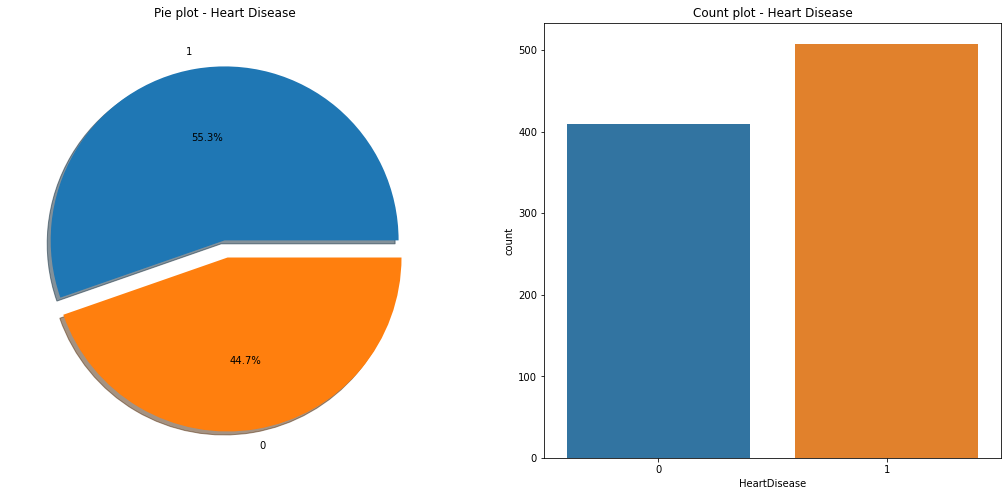

In [7]:
# 심부전증 여부
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df["HeartDisease"].value_counts().plot.pie(ax=ax[0], shadow=True, explode=[0, 0.1], autopct='%1.1f%%')
ax[0].set_title('Pie plot - Heart Disease')
ax[0].set_ylabel('')
sns.countplot('HeartDisease', data=df, ax=ax[1])
ax[1].set_title('Count plot - Heart Disease')

plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Age', ylabel='count'>

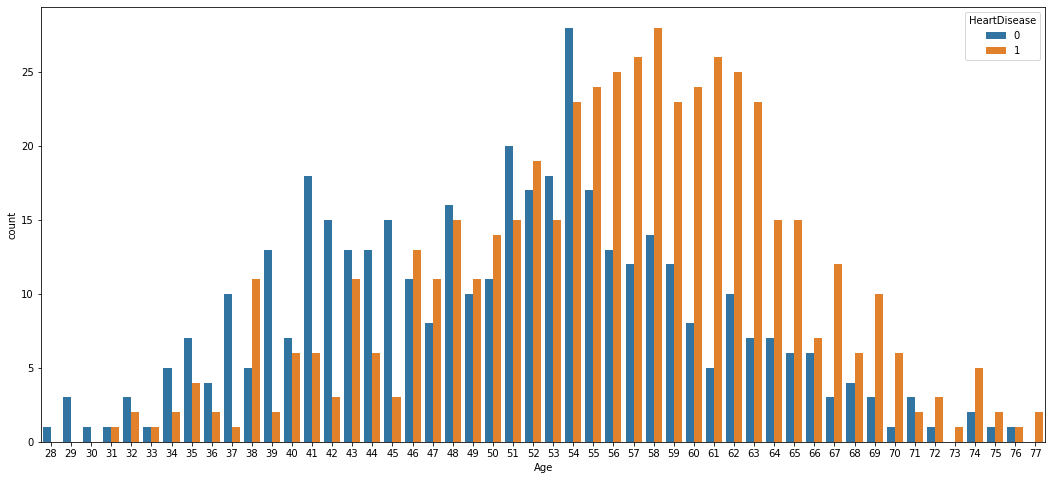

In [8]:
# 나이에 따른 심부전증
f, ax = plt.subplots(1, 1, figsize=(18, 8))
sns.countplot('Age', hue='HeartDisease', data=df, ax=ax)

In [9]:
df[['Age', 'HeartDisease']].groupby('HeartDisease', as_index=True).mean()

,Age
HeartDisease,
0,50.551220
1,55.899606


In [10]:
# 성별에 따른 심부전증
# 남자가 훨씬 많이 걸림
df[['Sex','HeartDisease']].groupby(['Sex'], as_index=True).mean().sort_values(by='HeartDisease', ascending=False)

,HeartDisease
Sex,
M,0.631724
F,0.259067


In [11]:
pd.crosstab(df['Sex'],df['HeartDisease'], margins=True)

HeartDisease,0,1,All
Sex,,,
F,143,50,193
M,267,458,725
All,410,508,918


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='ChestPainType', ylabel='count'>

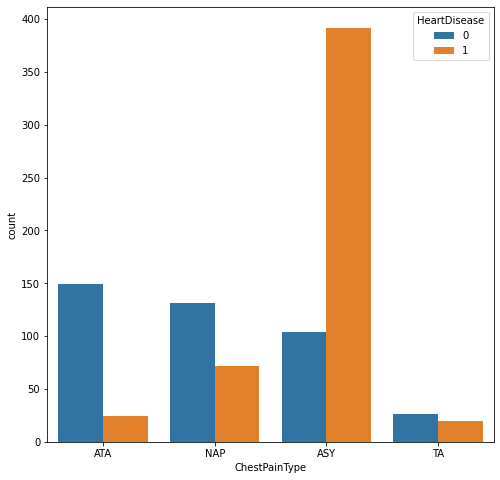

In [12]:
# 가슴통증 유형에 따른 심부전
f, ax = plt.subplots(1, 1, figsize=(8,8))

sns.countplot('ChestPainType', hue='HeartDisease', data=df)

<AxesSubplot:xlabel='ChestPainType'>

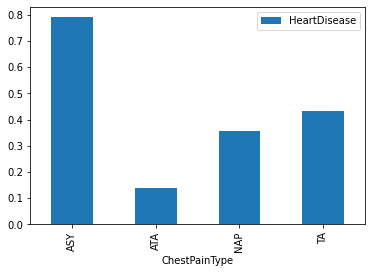

In [13]:
df[['ChestPainType', 'HeartDisease']].groupby(['ChestPainType'], as_index=True).mean().plot.bar()

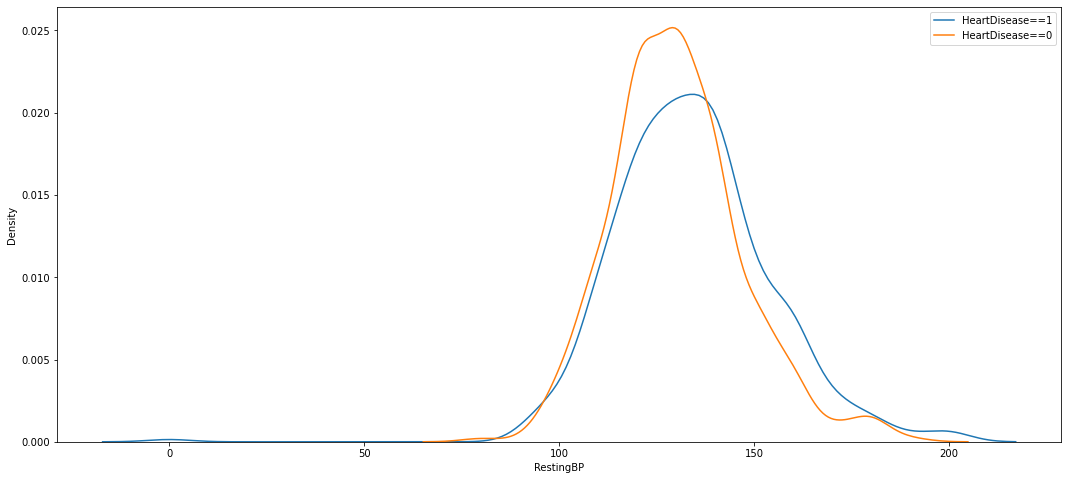

In [14]:
# 혈압에 따른 심부전
# 크게 상관없음
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
sns.kdeplot(df[df['HeartDisease']==1]['RestingBP'], ax=ax)
sns.kdeplot(df[df['HeartDisease']==0]['RestingBP'], ax=ax)
plt.legend(['HeartDisease==1', 'HeartDisease==0'])
plt.show()

<AxesSubplot:xlabel='HeartDisease'>

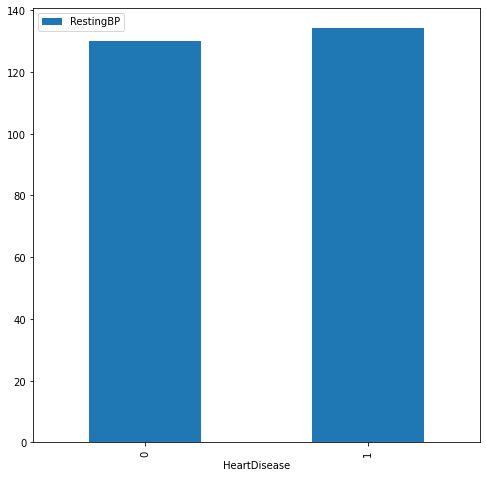

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

df[['RestingBP','HeartDisease']].groupby(['HeartDisease'],as_index=True).mean().plot.bar(ax=ax)

<AxesSubplot:xlabel='HeartDisease'>

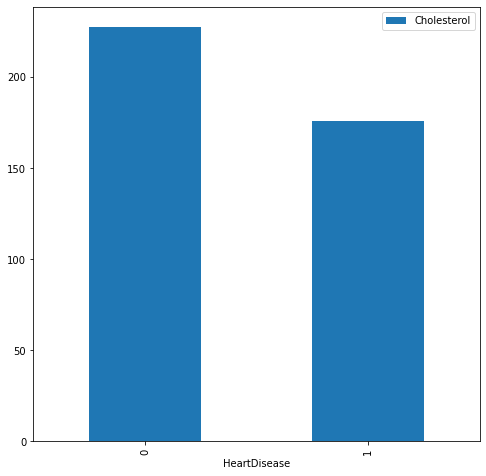

In [16]:
# 콜레스테롤
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

df[['Cholesterol', 'HeartDisease']].groupby(['HeartDisease'], as_index=True).mean().plot.bar(ax=ax)

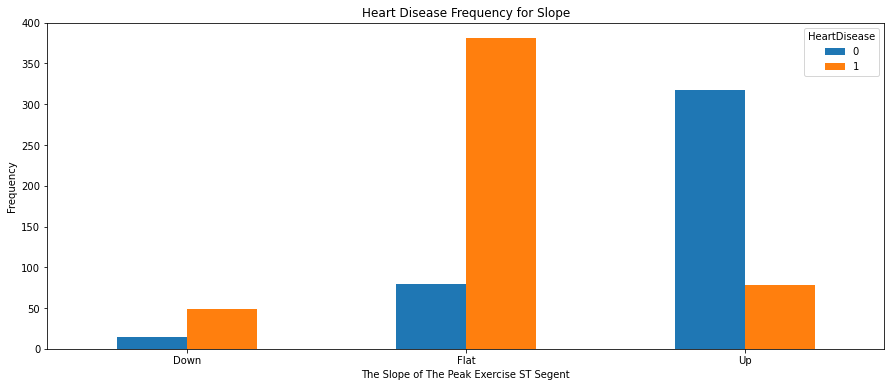

In [17]:
pd.crosstab(df.ST_Slope, df.HeartDisease).plot(kind='bar', figsize=(15, 6))
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segent')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

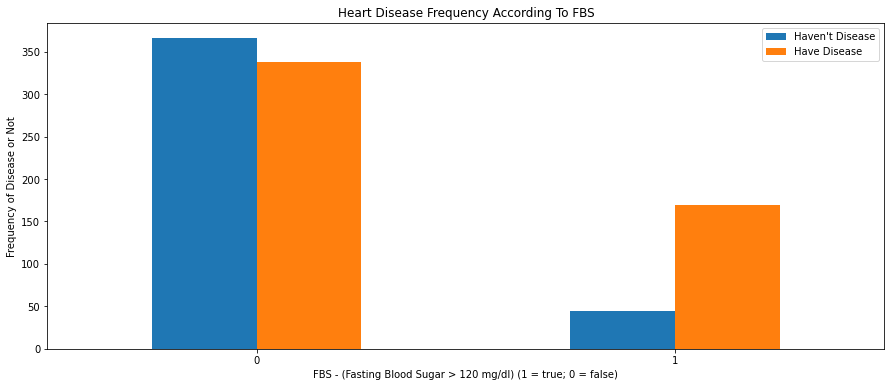

In [18]:
pd.crosstab(df.FastingBS, df.HeartDisease).plot(kind='bar', figsize=(15,6))
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

## Input, Feature 설정

In [19]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [20]:
Label = df['HeartDisease']
InputFeature = df[["Age","RestingBP","Cholesterol","FastingBS",
                   "MaxHR"]]

In [21]:
InputFeature.shape

(918, 5)

## Keras Logit 모델 fitting

In [22]:
model = Sequential()
model.add(Dense(6, activation='linear', input_shape=(5,)))
model.add(Dense(12, activation='linear'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

## Keras 모델 살펴보기

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 36        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


## Call-back 함수
## 모델 학습

In [24]:
# Call-back 함수
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='Models/{epoch:03d}-{loss:.4f}-{accuracy:.4f}.hdf5',
            monitor='loss', verbose=1, save_best_only=True, mode='min')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, LR]

In [25]:
InputFeature.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR
0,40,140,289,0,172
1,49,160,180,0,156
2,37,130,283,0,98
3,48,138,214,0,108
4,54,150,195,0,122


In [26]:
model.fit(x=InputFeature, y=Label, epochs=100, shuffle=True, batch_size=3, callbacks=CALLBACK)

Epoch 1/100
146/306 [=============>................] - ETA: 0s - loss: 3.4054 - accuracy: 0.5936  

2022-07-11 19:49:24.976468: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Epoch 1: loss improved from inf to 2.06843, saving model to Models/001-2.0684-0.6024.hdf5
306/306 [==============================] - 0s 348us/step - loss: 2.0684 - accuracy: 0.6024 - lr: 0.0100
Epoch 2/100
177/306 [================>.............] - ETA: 0s - loss: 0.7442 - accuracy: 0.6215
Epoch 2: loss improved from 2.06843 to 0.73441, saving model to Models/002-0.7344-0.6307.hdf5
306/306 [==============================] - 0s 307us/step - loss: 0.7344 - accuracy: 0.6307 - lr: 0.0100
Epoch 3/100
177/306 [================>.............] - ETA: 0s - loss: 0.7432 - accuracy: 0.6365
Epoch 3: loss improved from 0.73441 to 0.71598, saving model to Models/003-0.7160-0.6340.hdf5
306/306 [==============================] - 0s 307us/step - loss: 0.7160 - accuracy: 0.6340 - lr: 0.0100
Epoch 4/100
179/306 [================>.............] - ETA: 0s - loss: 0.6338 - accuracy: 0.6946
Epoch 4: loss improved from 0.71598 to 0.67528, saving model to Models/004-0.6753-0.6678.hdf5
306/306 [===============

170/306 [===============>..............] - ETA: 0s - loss: 0.5825 - accuracy: 0.6941
Epoch 30: loss did not improve from 0.57765
306/306 [==============================] - 0s 296us/step - loss: 0.5843 - accuracy: 0.6841 - lr: 0.0051
Epoch 31/100
175/306 [================>.............] - ETA: 0s - loss: 0.5861 - accuracy: 0.6686
Epoch 31: loss did not improve from 0.57765

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.
306/306 [==============================] - 0s 286us/step - loss: 0.5822 - accuracy: 0.6939 - lr: 0.0051
Epoch 32/100
175/306 [================>.............] - ETA: 0s - loss: 0.5707 - accuracy: 0.7010
Epoch 32: loss did not improve from 0.57765
306/306 [==============================] - 0s 290us/step - loss: 0.5798 - accuracy: 0.6863 - lr: 0.0041
Epoch 33/100
177/306 [================>.............] - ETA: 0s - loss: 0.5543 - accuracy: 0.6968
Epoch 33: loss did not improve from 0.57765
306/306 [==============================] - 0s 288us/step

Epoch 60/100
172/306 [===============>..............] - ETA: 0s - loss: 0.5700 - accuracy: 0.7054    
Epoch 60: loss improved from 0.56635 to 0.56422, saving model to Models/060-0.5642-0.7059.hdf5
306/306 [==============================] - 0s 317us/step - loss: 0.5642 - accuracy: 0.7059 - lr: 8.5899e-04
Epoch 61/100
178/306 [================>.............] - ETA: 0s - loss: 0.5727 - accuracy: 0.6985
Epoch 61: loss did not improve from 0.56422
306/306 [==============================] - 0s 287us/step - loss: 0.5658 - accuracy: 0.7015 - lr: 8.5899e-04
Epoch 62/100
176/306 [================>.............] - ETA: 0s - loss: 0.5627 - accuracy: 0.6989
Epoch 62: loss did not improve from 0.56422
306/306 [==============================] - 0s 287us/step - loss: 0.5666 - accuracy: 0.6939 - lr: 8.5899e-04
Epoch 63/100
173/306 [===============>..............] - ETA: 0s - loss: 0.5770 - accuracy: 0.6840
Epoch 63: loss did not improve from 0.56422

Epoch 63: ReduceLROnPlateau reducing learning rate t

173/306 [===============>..............] - ETA: 0s - loss: 0.5782 - accuracy: 0.6782
Epoch 89: loss did not improve from 0.56230

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0001801439793780446.
306/306 [==============================] - 0s 292us/step - loss: 0.5626 - accuracy: 0.6928 - lr: 2.2518e-04
Epoch 90/100
172/306 [===============>..............] - ETA: 0s - loss: 0.5413 - accuracy: 0.7093
Epoch 90: loss improved from 0.56230 to 0.56191, saving model to Models/090-0.5619-0.7059.hdf5
306/306 [==============================] - 0s 312us/step - loss: 0.5619 - accuracy: 0.7059 - lr: 1.8014e-04
Epoch 91/100
176/306 [================>.............] - ETA: 0s - loss: 0.5616 - accuracy: 0.7102
Epoch 91: loss did not improve from 0.56191
306/306 [==============================] - 0s 285us/step - loss: 0.5622 - accuracy: 0.7004 - lr: 1.8014e-04
Epoch 92/100
177/306 [================>.............] - ETA: 0s - loss: 0.5720 - accuracy: 0.6761
Epoch 92: loss did not improve from 

# Model Load 하기 전, hdf5 파일 이름 꼭 확인하기

In [27]:
model.load_weights("Models/096-0.5612-0.6961.hdf5")

In [28]:
# Jupyter notebook, web interface 이므로 javascript를 초기화 해야됨
shap.initjs()

# shap를 활용해서 explainer 객체를 정의
explainer = shap.KernelExplainer(model, InputFeature)

Using 918 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [29]:
# shap_values에는 각 변수의 중요도가 담김
shap_values = explainer.shap_values(InputFeature.iloc[:20,:], nsamples=500)

  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
len(shap_values[0])

20

In [31]:
sumValues = np.zeros(len(InputFeature.columns))
for values in shap_values[0]:
    sumValues += values
    
shap_values_mean = sumValues / len(shap_values[0])

In [32]:
Data = pd.DataFrame({
    'Importance' : shap_values_mean,
    'Features' : InputFeature.columns
})

Data

,Importance,Features
0,-0.071078,Age
1,-0.011468,RestingBP
2,-0.017592,Cholesterol
3,-0.038377,FastingBS
4,-0.020823,MaxHR


In [33]:
# shap_values

In [34]:
# Data = pd.DataFrame({
#     'Importance': shap_values[0],
#     'Features':InputFeature.columns
# })
# Data

<AxesSubplot:xlabel='Importance', ylabel='Features'>

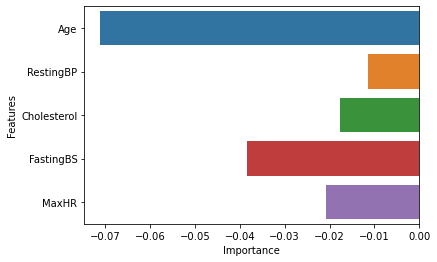

In [35]:
import seaborn

seaborn.barplot(
    data= Data,
    x= "Importance",
    y= "Features"    
)

## FLASK 셋팅하기

In [36]:
from flask import Flask
from flask import render_template
from flask import request

In [37]:
app = Flask(__name__)

# FLASK API 구현부분

In [38]:
@app.route('/')
@app.route('/HeartDisease')
def HeartDiseasePrediction():
    Age = request.args.get("Age")
    RestingBP = request.args.get("RestingBP")
    Cholesterol = request.args.get("Cholesterol")
    FastingBS = request.args.get("FastingBS")
    MaxHR = request.args.get("MaxHR")
    
       
    if Age == None or RestingBP == None or Cholesterol == None or FastingBS == None or MaxHR == None:
        return render_template('HeartDisease.html', Output = '')
    
    Input = pd.DataFrame({
        'Age': [ float(Age) ],
        'RestingBP': [ float(RestingBP) ],
        'Cholesterol': [ float(Cholesterol) ],
        'FastingBS': [ float(FastingBS) ],
        'MaxHR': [ float(MaxHR) ]
    })
    ModelOutput = model.predict(Input)[0][0]

    return render_template('HeartDisease.html', Output = round((ModelOutput * 100),2))

# Flask, port 5000으로 실행

In [ ]:
app.run(host='0.0.0.0', port=5000)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.186.24.57:5000 (Press CTRL+C to quit)
127.0.0.1 - - [11/Jul/2022 19:49:39] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Jul/2022 19:49:50] "GET /HeartDisease?Age=30&RestingBP=120&Cholesterol=100&MaxHR=189&FastingBS=1 HTTP/1.1" 200 -


In [ ]:
# http://127.0.0.1:5000/HeartDisease?Age=40&RestingBP=180&Cholesterol=200&MaxHR=180